In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import legwork

import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw
from seaborn_utility import cmap_from_colour

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [3]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../data/simulation_plus_supp/"

total_DCOs_in_MW = np.load("../data/total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load("../data/total_DCO_in_MW_nohubble.npy")

detections = np.load("../data/detections_4yr.npy")
detections_10yr = np.load("../data/detections_10yr.npy")

# Fiducial Simulation Analysis

## Detectable Harmonics

In [4]:
def number_of_detectable_harmonics(m_c, dist, f_orb, ecc, snr_cutoff=7, t_obs=4 * u.yr, nmax=50):
    
    # calculate the strain for each of the n harmonics and convert to signal over LISA mission
    n_range = np.arange(1, nmax).astype(int)
    hn = legwork.strain.h_0_n(m_c=m_c, dist=dist, f_orb=f_orb, n=n_range, ecc=ecc)
    signal_n_squared = t_obs * hn[:,0,:]**2

    # find the square of the noise at each of the harmonic frequency for a mission of length t_obs
    noise_n_squared = legwork.psd.lisa_psd(f=f_orb[:, np.newaxis] * n_range, t_obs=t_obs)

    # calculate the SNR as the ratio of these quantities
    snr_n_squared = (signal_n_squared / noise_n_squared).decompose()
    
    return (snr_n_squared > snr_cutoff).astype(int).sum(axis=1)

0
1
2


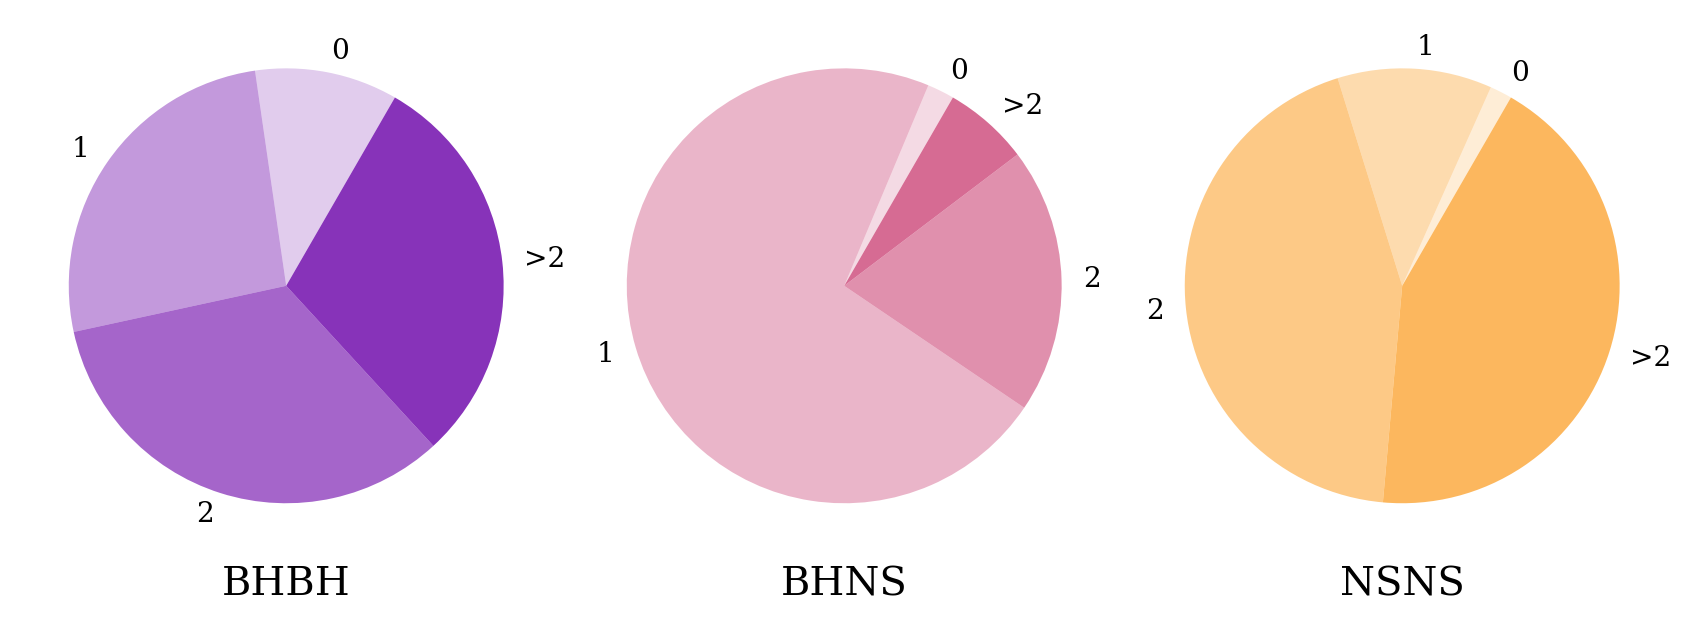

In [185]:
nharm_4yr = {"BHBH": None, "BHNS": None, "NSNS": None}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.subplots_adjust(wspace=0.0)

t_obs = 4 * u.yr

for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > 7
        data = full_data[snr_mask]
        
    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(data["a_LISA"] * u.AU,
                                                data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    nharm[dco_types[i]] = number_of_detectable_harmonics(m_c, data["dist"] * u.kpc, f_orb_LISA, data["e_LISA"], snr_cutoff=2)
    harmonics, counts = np.unique(nharm[dco_types[i]], return_counts=True)
    sizes = [counts[0], counts[1], counts[2], counts[3:].sum()]
    labels = ["0", "1", "2", ">2"]
    colors = [dco_colours[dco_types[i]][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
    ax[i].pie(sizes, labels=labels, startangle=60, colors=colors)
    ax[i].set_xlabel(dco_types[i])
    print(i)

plt.show()

0
1
2


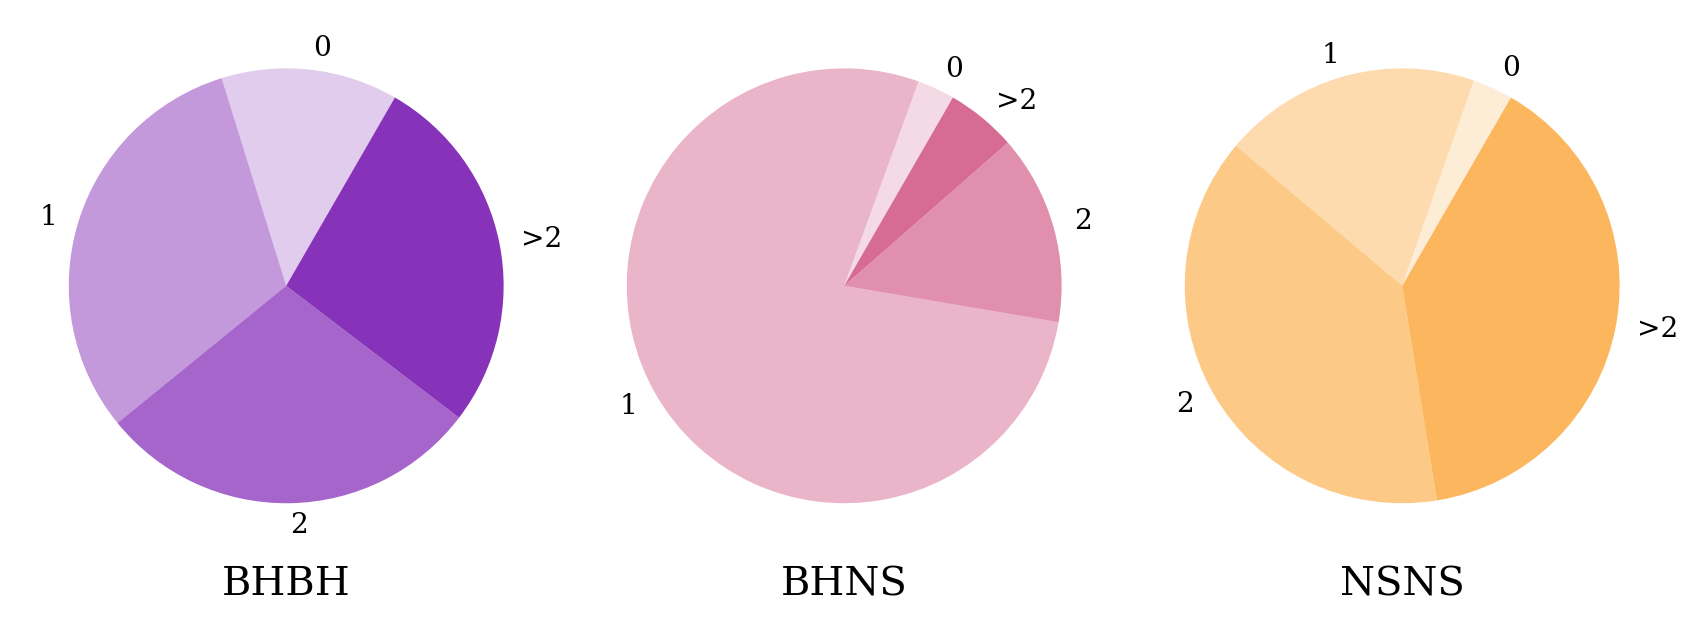

In [188]:
nharm_10yr = {"BHBH": None, "BHNS": None, "NSNS": None}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.subplots_adjust(wspace=0.0)

t_obs = 10 * u.yr

for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > 7
        data = full_data[snr_mask]
        
    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(data["a_LISA"] * u.AU,
                                                data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    nharm[dco_types[i]] = number_of_detectable_harmonics(m_c, data["dist"] * u.kpc, f_orb_LISA, data["e_LISA"], snr_cutoff=2)
    harmonics, counts = np.unique(nharm[dco_types[i]], return_counts=True)
    sizes = [counts[0], counts[1], counts[2], counts[3:].sum()]
    labels = ["0", "1", "2", ">2"]
    colors = [dco_colours[dco_types[i]][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
    ax[i].pie(sizes, labels=labels, startangle=60, colors=colors)
    ax[i].set_xlabel(dco_types[i])
    print(i)

plt.show()

## Parameter distributions

In [6]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def f_uncertainty(snr, t_obs, f):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f).decompose()

def fdot_uncertainty(snr, t_obs, fdot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / fdot).decompose()

def Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)

26657
22736
18207


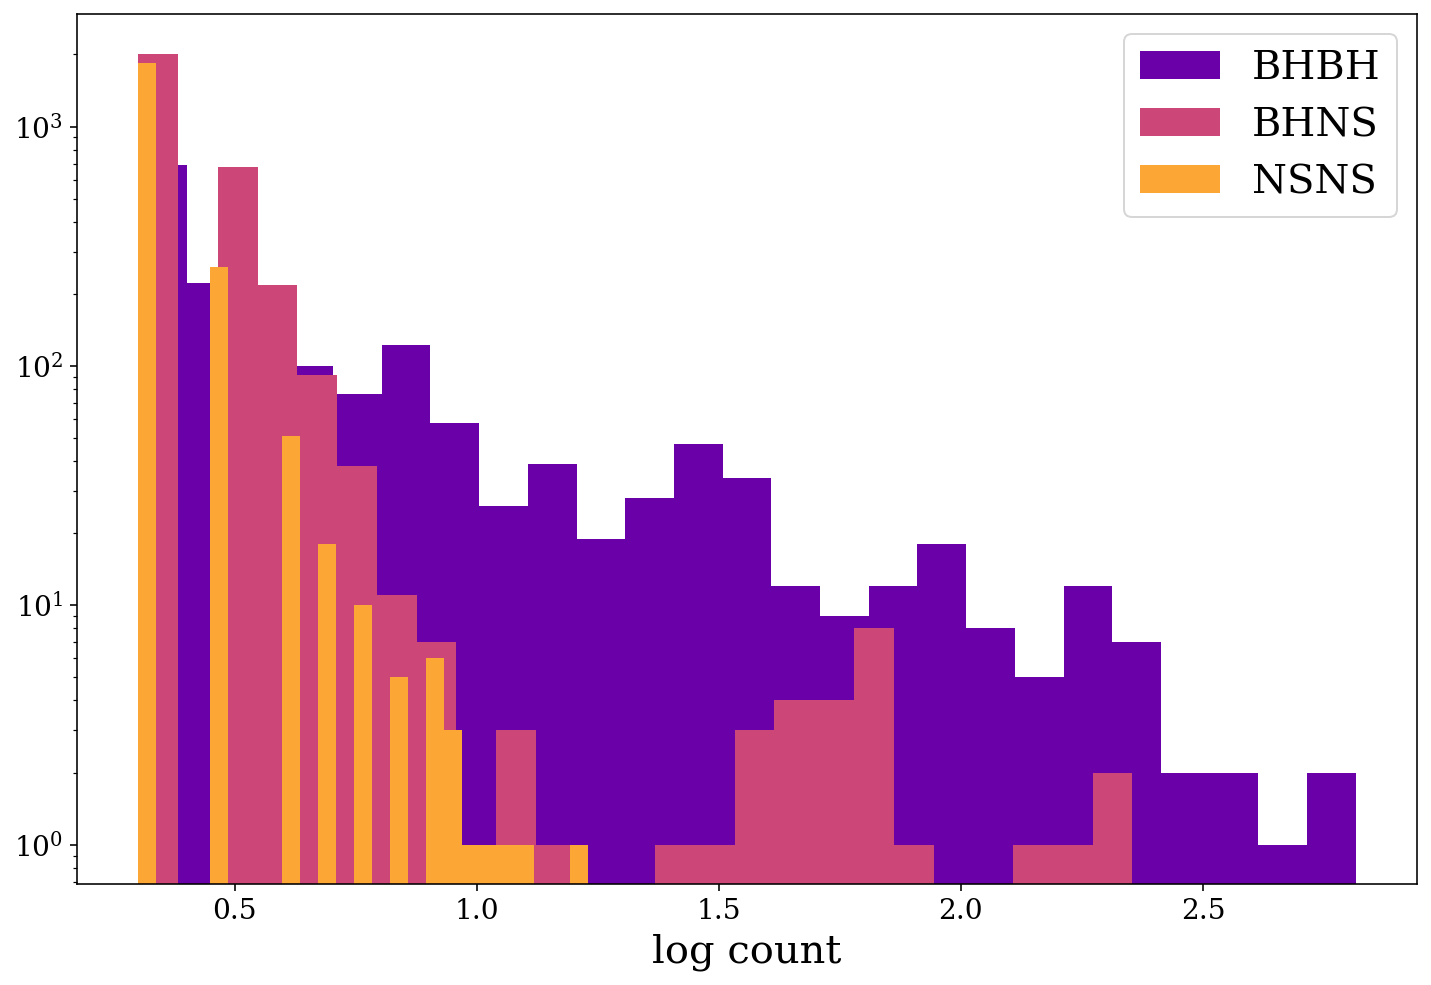

In [21]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    print(len(data["seed"]))
    uniques, counts = np.unique(data["seed"], return_counts=True)
    plt.hist(np.log10(counts[counts > 1]), color=dco_colours[dco_type], bins=25, label=dco_type)

plt.legend()

plt.xlabel("log count")
plt.yscale("log")
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


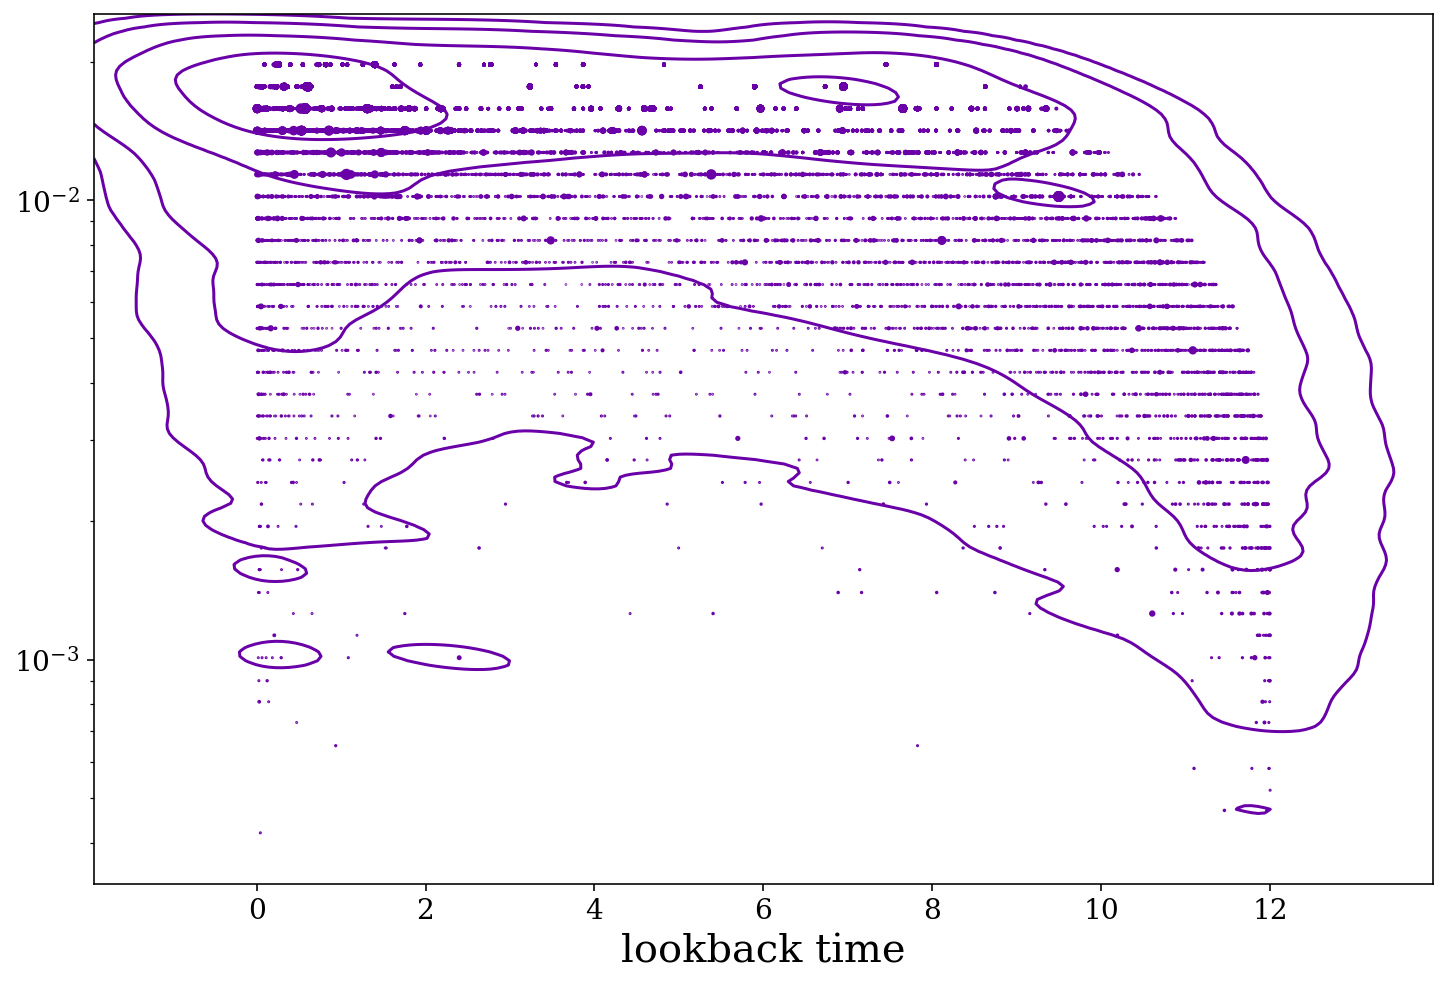

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


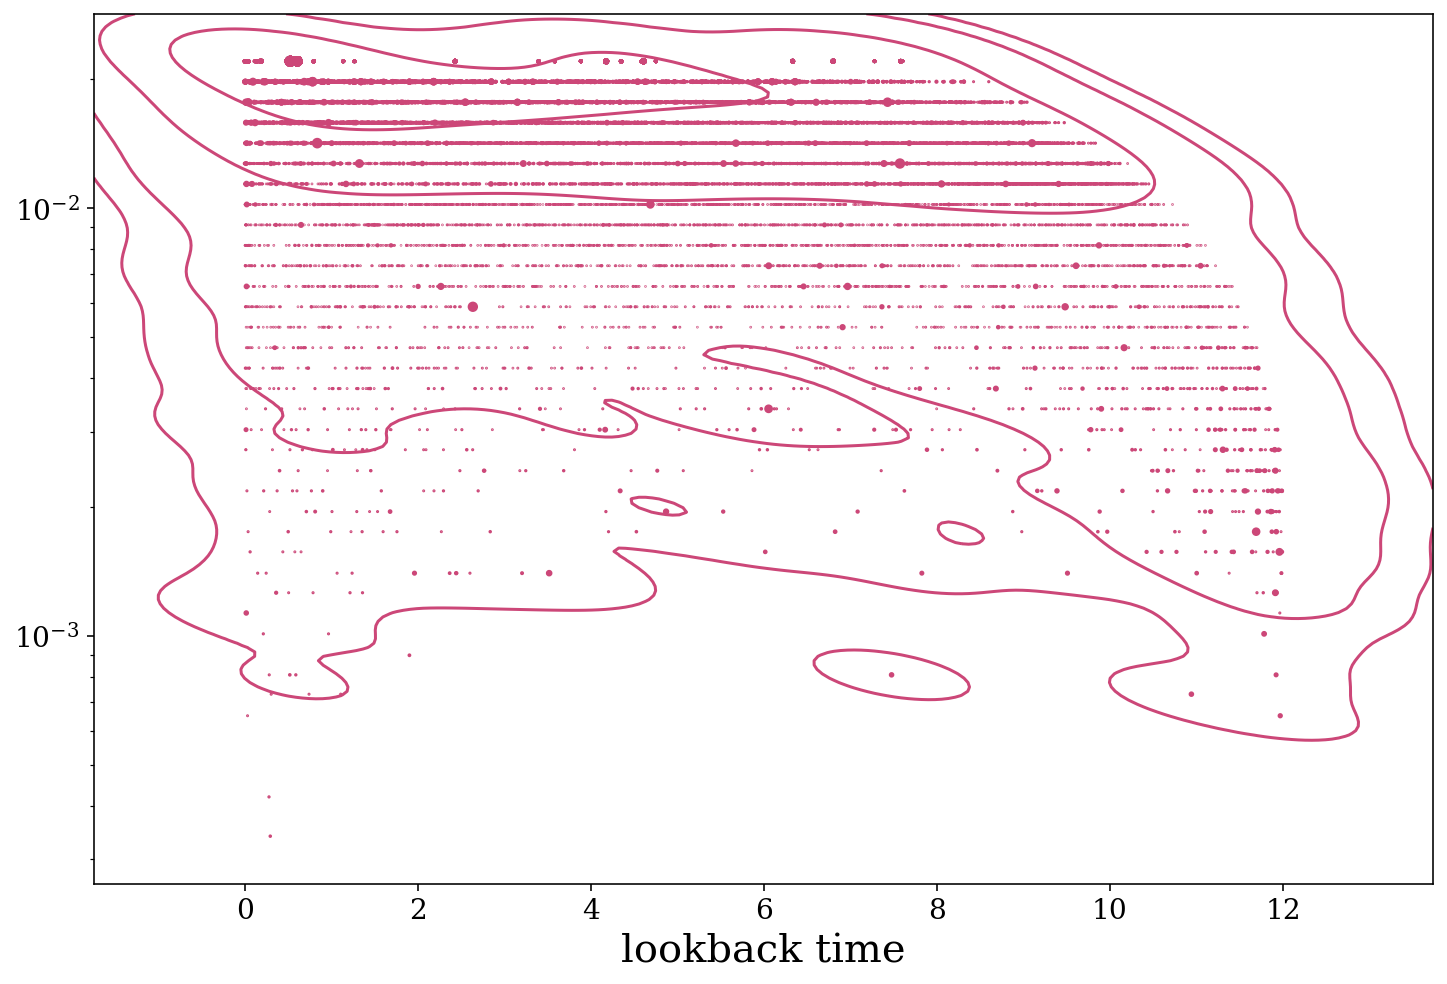

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


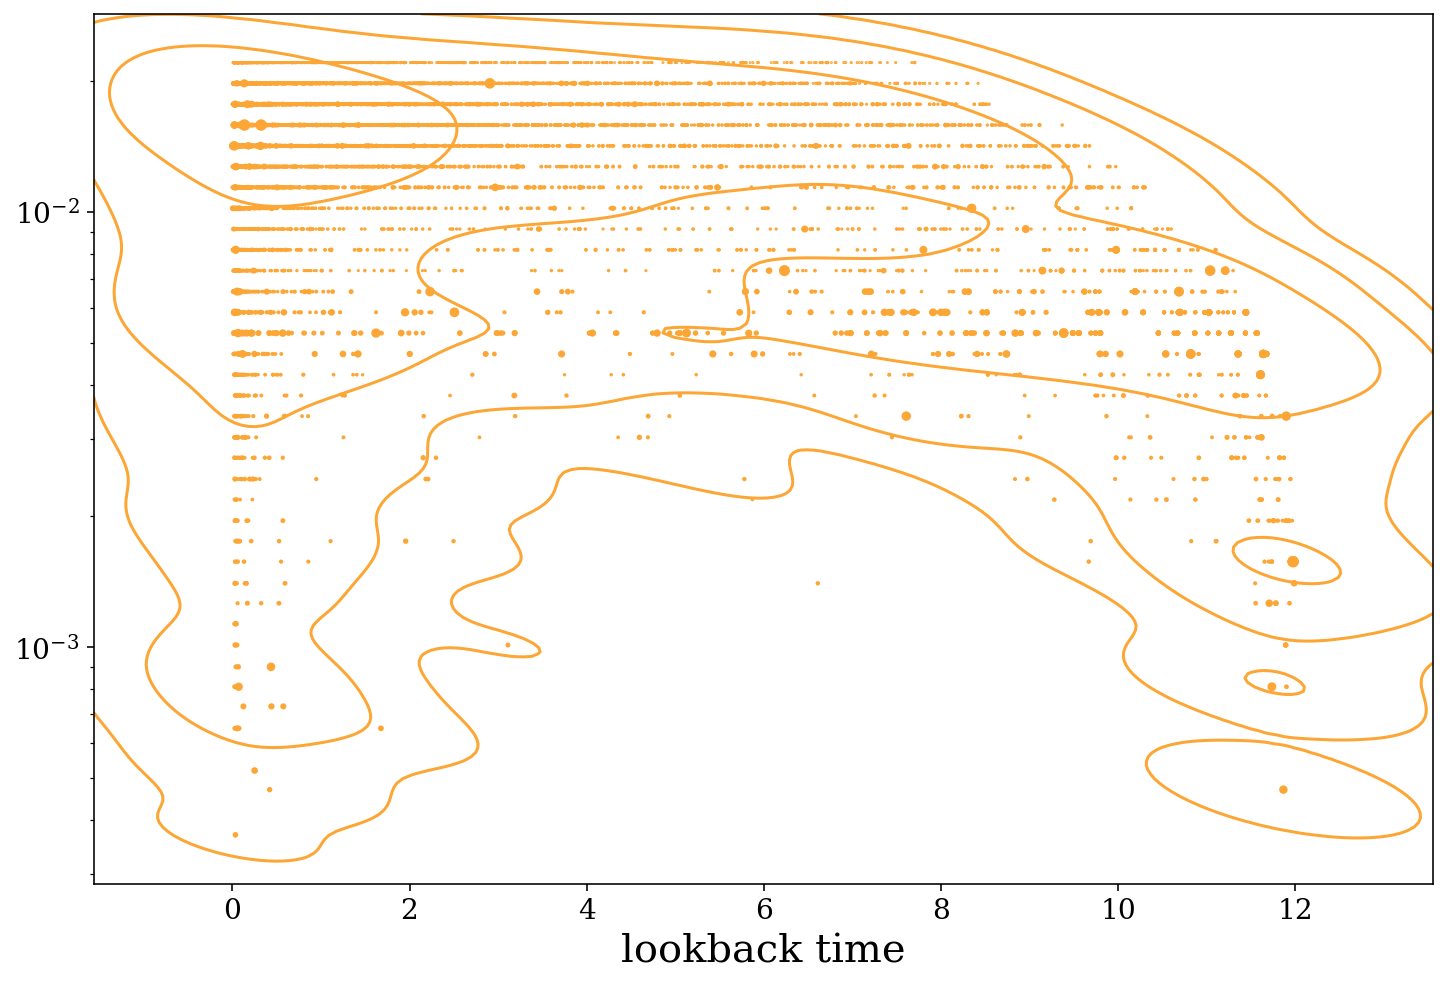

In [35]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    plt.scatter(data["tau"], data["Z"], s=data["weight"] * 25, color=dco_colours[dco_type])
    sns.kdeplot(data["tau"], data["Z"], weights=data["weight"], color=dco_colours[dco_type], log_scale=(False, True), levels=[0.001, 0.01, 0.1, 0.5])

    plt.xlabel("lookback time")
#     plt.yscale("log")
    plt.show()

In [189]:
def grid_plot(model=0, t_obs=10 * u.yr, unique=False, count_limit=50):
    fig, axes = plt.subplots(3, 3, figsize=(22, 15))

    plt.subplots_adjust(top=0.97, hspace=0.25)
    
    lw = 4

    Z_vals = np.concatenate((np.logspace(-4, np.log10(0.022), 50).round(5), [0.0244,  0.02705, 0.03]))
    inner_bins = np.array([Z_vals[i]
                           + (Z_vals[i+1] - Z_vals[i])
                           / 2 for i in range(len(Z_vals) - 1)])
    Z_bins = np.concatenate(([Z_vals[0]], inner_bins,
                             [Z_vals[-1]]))
    
    for i, dco_type in enumerate(["BHBH", "BHNS", "NSNS"]):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            if unique:
                _, places = np.unique(data["seed"], return_index=True)
                data = data[places]
                
            unique_seeds, counts = np.unique(data["seed"], return_counts=True)
            count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])
            
            data = data[count_mask]
            
        detection_total = detections if t_obs == 4 * u.yr else detections_10yr

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        D_fdot = fdot_uncertainty(data["snr"] , t_obs, f_dot)
        D_f = f_uncertainty(data["snr"], t_obs, f_orb_LISA)
        
        if t_obs == 4 * u.yr:
            D_e = np.where(nharm_4yr[dco_type] > 1, 0.05, np.where(nharm_4yr[dco_type] == 0, 1, 0.1))
        else:
            D_e = np.where(nharm_10yr[dco_type] > 1, 0.05, np.where(nharm_10yr[dco_type] == 0, 1, 0.1))[count_mask]
        D_Mc = 11 / 5 * D_f + 3 / 5 * D_fdot + 3 / 5 * Fprime_over_F(data["e_LISA"]) * D_e

        localised = sigma_theta <= np.sqrt(0.67 / np.pi) * u.deg
        distinguished = D_Mc <= 0.1
        print(variations[model]["med"])
        print(dco_type, len(data["m_1"]))
        print("\tDetections {:1.2f}".format(detection_total[i][model].mean()))
        print("\tLocalised detections {:1.2f}".format(detection_total[i][model].mean()
                                                      * len(data[localised]) / len(data)))
        print("\tDistinguished detections {:1.2f}".format(detection_total[i][model].mean()
                                                          * len(data[distinguished]) / len(data)))
        print("\tLocalised AND distinguished detections {:1.2f}".format(detection_total[i][model].mean()
                                                                        * len(data[np.logical_and(localised, distinguished)]) / len(data)))

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            sns.kdeplot(mBH, weights=mass_weights, ax=axes[0, 0], bw_adjust=1.4, color=dco_colours[dco_type], lw=lw, label=dco_type)
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2, 20)

        if dco_type in ["BHNS", "NSNS"]:
            sns.kdeplot(mNS, weights=mass_weights, ax=axes[0, 1], bw_adjust=0.8, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type, log_scale=(False, True))
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)
            
        sns.kdeplot(f_orb_LISA.value, weights=data["weight"], ax=axes[0, 2], bw_adjust=1, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type, log_scale=(True, False))
        axes[0, 2].set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} /, [{\rm Hz}]$")
        axes[0, 2].set_xlim(9e-6, 9e-3)

        sns.kdeplot(data["dist"], weights=data["weight"], ax=axes[1, 0], bw_adjust=1, color=dco_colours[dco_type], cut=0, lw=lw, label=dco_type)
        axes[1, 0].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 0].set_xlim(0, 25)
        axes[1, 0].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 0].annotate("Milky Way Centre", xy=(8.2, 0.05), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        sns.kdeplot(data["tau"], weights=data["weight"], ax=axes[1, 1], bw_adjust=1, color=dco_colours[dco_type], lw=lw, label=dco_type, cut=0)
        axes[1, 1].set_xlabel(r"Lookback Time, $\tau \, [\rm Gyr]$")
        axes[1, 1].set_xlim(0, 12)
        
        hist, _ = np.histogram(data["Z"], bins=Z_bins, weights=data["weight"], density=True)
        nonzero = hist > 0
        axes[1, 2].plot(Z_vals[nonzero], hist[nonzero], color=dco_colours[dco_type], zorder=-1)
        axes[1, 2].scatter(Z_vals[nonzero], hist[nonzero], s=40, color=dco_colours[dco_type])        
        axes[1, 2].set_xscale("log")
        axes[1, 2].set_yscale("log")
        axes[1, 2].set_xlim(3e-4, 0.024)
        axes[1, 2].set_xlabel(r"Metallicity, $Z$")
        
        sns.ecdfplot(x=np.log10(D_Mc.value), weights=data["weight"] / np.sum(data["weight"]) * detection_total[i][model].mean(),
                     ax=axes[2, 0], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2, 0].set_xlabel(r"Chirp Mass Error, $\log_{10}(\Delta \mathcal{M}_c / \mathcal{M}_c)$")
        axes[2, 0].set_xlim(-4.1, 2.5)
        axes[2, 0].axvspan(0, axes[2, 0].get_xlim()[1], color="grey", zorder=10, alpha=0.2)

        sns.ecdfplot(x=np.log10(data["e_LISA"]), weights=data["weight"] / np.sum(data["weight"]) * detection_total[i][model].mean(),
                     ax=axes[2, 1], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2, 1].set_xlabel(r"Eccentricity, $\log_{10}(e_{\rm LISA})$")
        axes[2, 1].set_xlim(-3.9, 0)
        axes[2, 1].axvspan(axes[2, 1].get_xlim()[0], -2, color="grey", zorder=10, alpha=0.2)
        
        sns.ecdfplot(x=np.log10(sigma_theta.value), weights=data["weight"] / np.sum(data["weight"]) * detection_total[i][model].mean(),
                     ax=axes[2, 2], color=dco_colours[dco_type], lw=lw, label=dco_type, stat="count")
        axes[2, 2].set_xlabel(r"Angular Resolution, $\log_{10}(\sigma_{\theta} / {\rm ^\circ})$")
        axes[2, 2].set_xlim(-2.5, 3)
        
        telescopes = [("SKA", 0.67 * u.deg**2), ("JWST NIRCam", 9.7 * u.arcmin**2), ("GOTO-Present", 40 * u.deg**2), ("GOTO-2022", 160 * u.deg**2), ("Swift", (23.6 * u.arcmin)**2)]
        
        for name, area in telescopes:
            angular_resolution = np.sqrt(area / np.pi).to(u.deg)
            axes[2, 2].axvline(np.log10(angular_resolution.value), linestyle="dotted", color="grey")
            
            y = 42#8.7 if np.log10(angular_resolution.value) < 0 else 0.3
            va = "top"# if np.log10(angular_resolution.value) < 0 else "bottom"
            axes[2, 2].annotate(name, xy=(np.log10(angular_resolution.value), y), xycoords="data", rotation=90,
                             ha="center", va=va, fontsize=0.5*fs, color="grey", bbox=dict(boxstyle="round", fc="white", ec="white"))
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.kdeplot(D, ax=axes[1, 0], color="grey", bw_adjust=1.5, linestyle="dotted", cut=0)
    
    for Z in Z_vals:
        axes[1, 2].axvline(Z, zorder=-2, color="grey", linestyle="dotted", lw=0.5)
    
    handles, labels = axes[0, 2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
#         ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
    axes[0, 0].set_ylabel("PDF")
    axes[1, 0].set_ylabel("PDF")
    axes[2, 0].set_ylabel("Cumulative detections")

    if t_obs == 4 * u.yr:
        plt.savefig("../../paper/figures/distribution_grid_4yr.pdf", format="pdf", bbox_inches="tight")
    else:
        plt.savefig("../../paper/figures/distribution_grid_10yr.pdf", format="pdf", bbox_inches="tight")

    plt.show()

fiducial
BHBH 11984
	Detections 26.34
	Localised detections 1.14
	Distinguished detections 2.08
	Localised AND distinguished detections 1.11
fiducial
BHNS 20847
	Detections 26.95
	Localised detections 2.06
	Distinguished detections 3.15
	Localised AND distinguished detections 2.04
fiducial
NSNS 18207
	Detections 11.72
	Localised detections 1.64
	Distinguished detections 1.82
	Localised AND distinguished detections 1.58


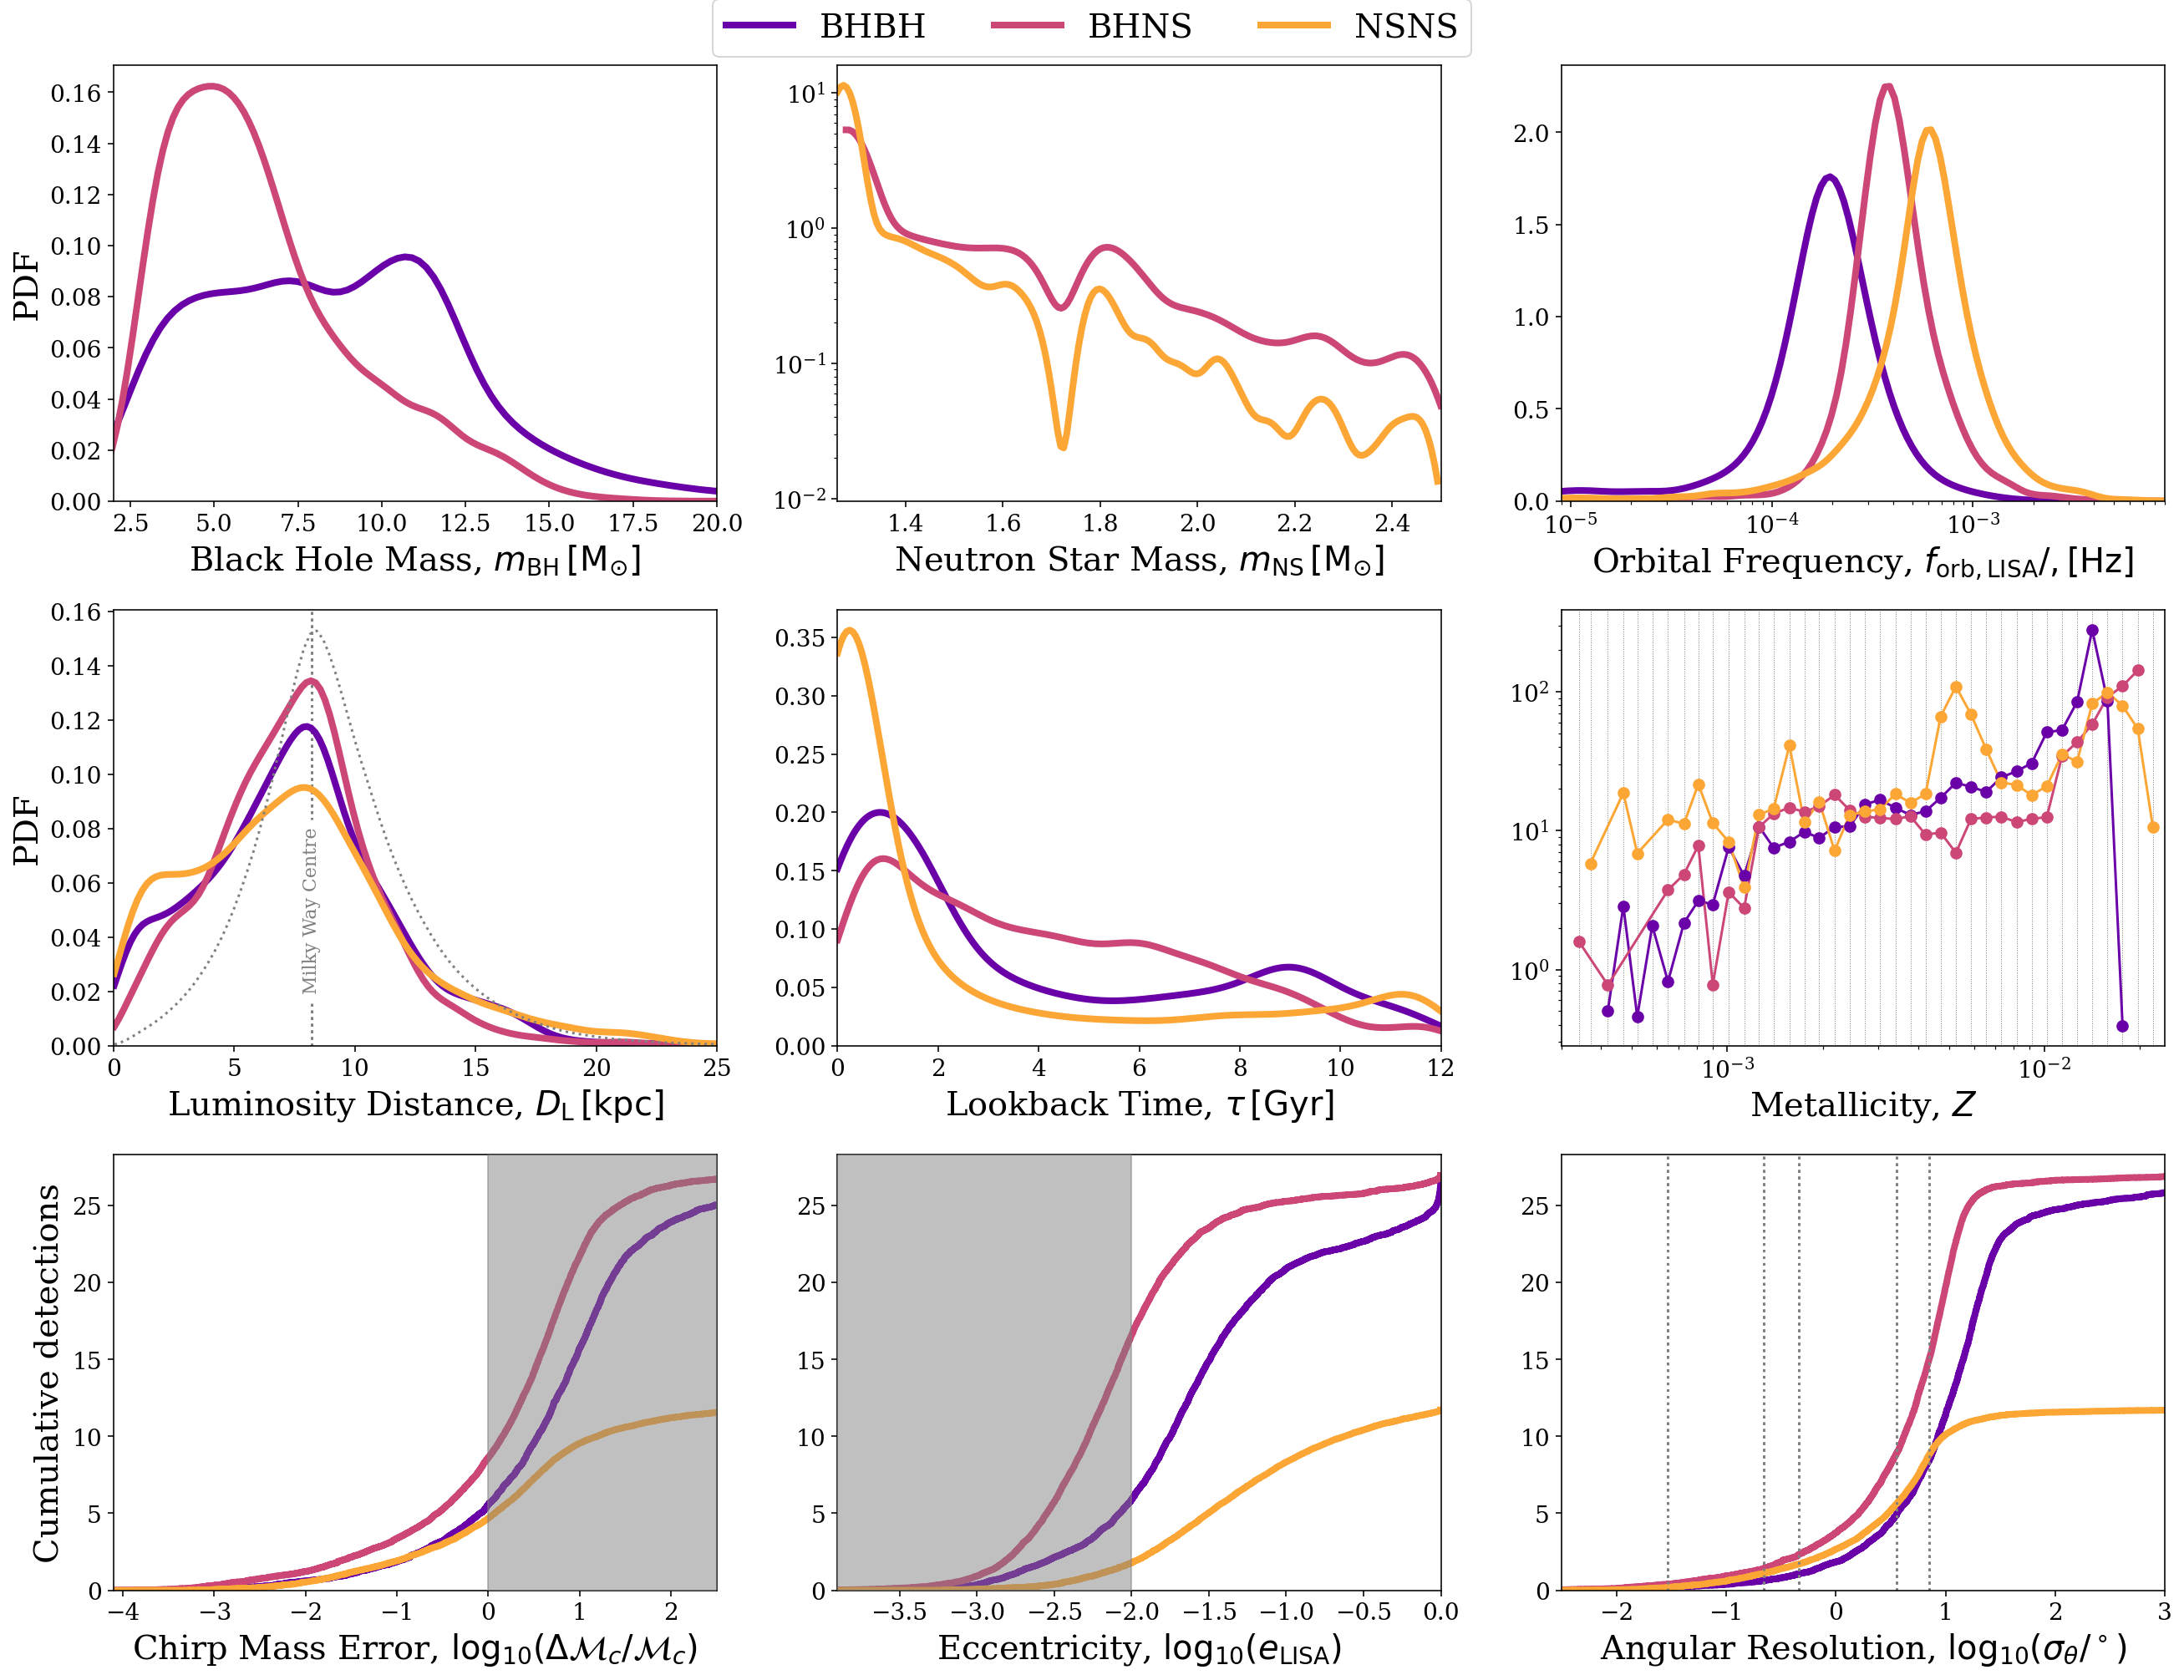

In [187]:
grid_plot(count_limit=25, t_obs=4 * u.yr)

In [31]:
def kdeplot_something(variable, dco_type_list=["BHBH", "BHNS", "NSNS"], variation_index=0,
                      fig=None, ax=None, show=True, count_limit=np.inf, channel=None, **kwargs):
    if fig is None or ax is None:   
        fig, ax = plt.subplots(1, figsize=(10, 5))

    for dco_type in dco_type_list:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] > 7

            data = full_data[snr_mask]
            
            unique_seeds, counts = np.unique(data["seed"], return_counts=True)
            count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])
            
            data = data[count_mask]
            if channel is not None:
                data = data[np.isin(data["channel"], channel)]

        sns.kdeplot(data[variable], weights=data["weight"], color=dco_colours[dco_type], cut=0, lw=4, **kwargs)

    if show:
        plt.show()
    return fig, ax

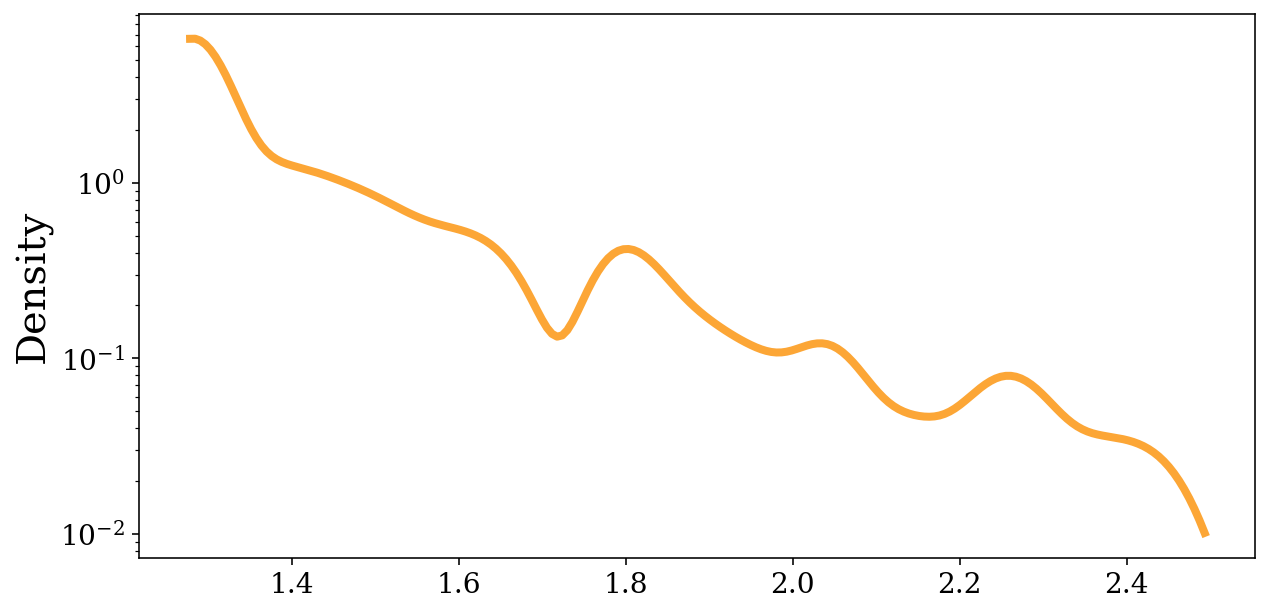

In [92]:
fig, ax = kdeplot_something("m_2", dco_type_list = ["NSNS"], count_limit=25, log_scale=(False, True))

[(0.417642, 0.000564, 0.65839, 1.0),
 (0.798216, 0.280197, 0.469538, 1.0),
 (0.98826, 0.652325, 0.211364, 1.0)]

(0.0003, 0.024)

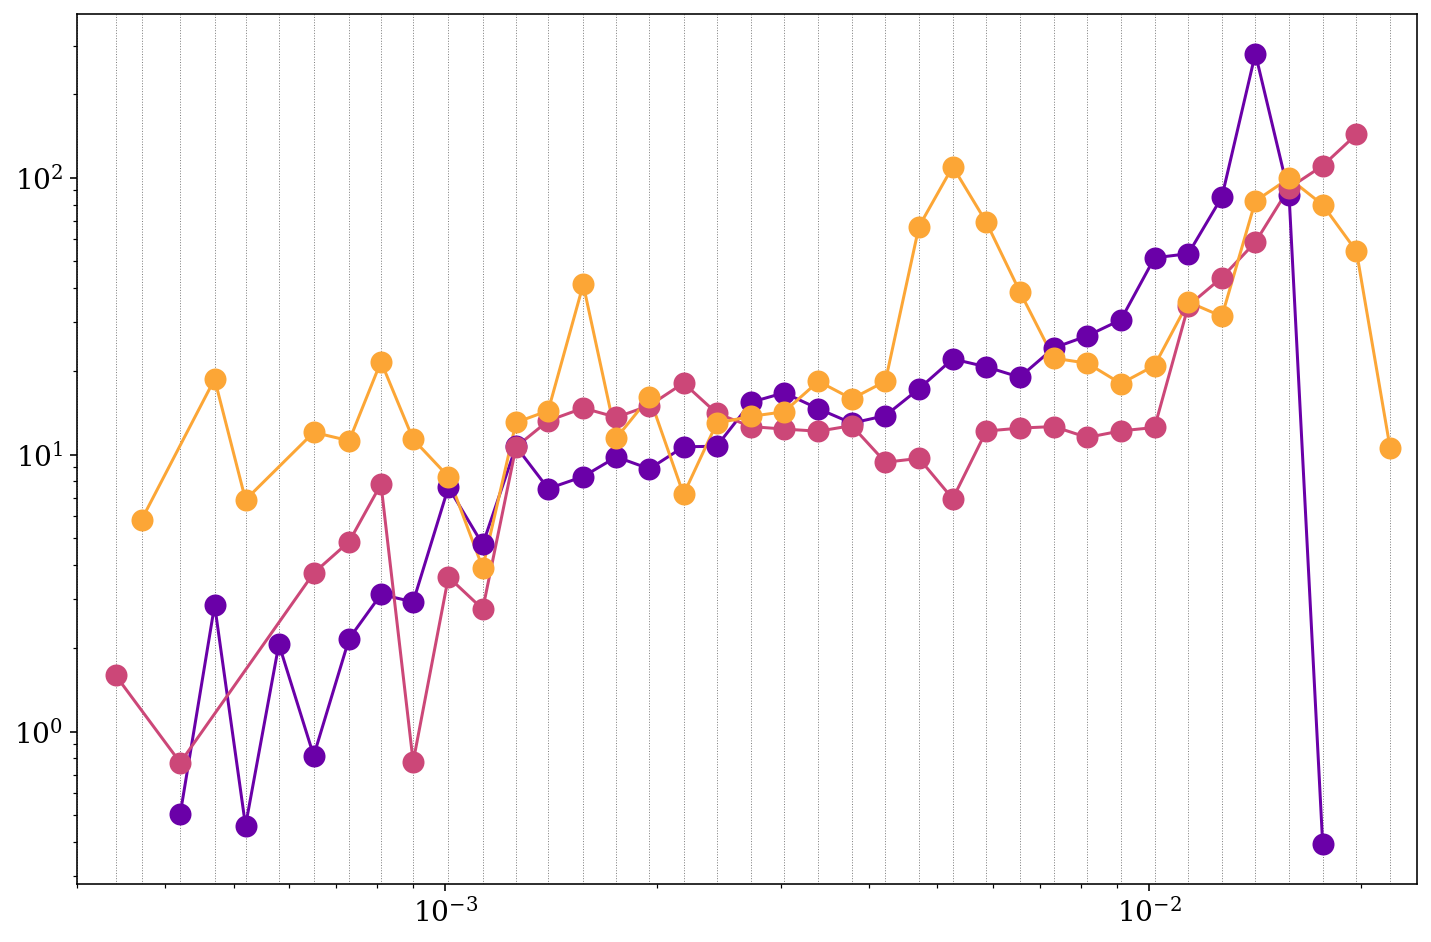

In [162]:
fig, ax = plt.subplots()

dco_type_list=["BHBH", "BHNS", "NSNS"]
count_limit = 25
variation_index=0

Z_vals = np.concatenate((np.logspace(-4, np.log10(0.022), 50).round(5), [0.0244,  0.02705, 0.03]))
inner_bins = np.array([Z_vals[i]
                       + (Z_vals[i+1] - Z_vals[i])
                       / 2 for i in range(len(Z_vals) - 1)])
Z_bins = np.concatenate(([Z_vals[0]], inner_bins,
                         [Z_vals[-1]]))

for i, dco_type in enumerate(dco_type_list):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7

        data = full_data[snr_mask]

        unique_seeds, counts = np.unique(data["seed"], return_counts=True)
        count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])

        data = data[count_mask]
        
        hist, _ = np.histogram(data["Z"], bins=Z_bins, weights=data["weight"], density=True)
        nonzero = hist > 0
        ax.plot(Z_vals[nonzero], hist[nonzero], color=dco_colours[dco_type], zorder=-1)
        ax.scatter(Z_vals[nonzero], hist[nonzero], s=100, color=dco_colours[dco_type])

for z in Z_vals:
    ax.axvline(z, zorder=-2, color="grey", linestyle="dotted", lw=0.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(3e-4, 0.024)
# ax.set_ylim(1e-1, 3e2)

$\dot{f}/T^2 > \pi / rho$ (or 1)

In [38]:
fid_sources = [None, None, None]
for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        
        data = full_data[snr_mask]
        
    fid_sources[i] = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                dist=data["dist"] * u.kpc, ecc=data["e_LISA"],
                                                a=data["a_LISA"] * u.AU)
    fid_sources[i].weight = data["weight"]

In [39]:
for i in range(len(dco_types)):
    fid_sources[i].get_snr(verbose=True)

Calculating SNR for 26657 sources
	26653 sources are stationary
		15212 sources are stationary and circular
		11441 sources are stationary and eccentric
	4 sources are evolving
		4 sources are evolving and circular
Calculating SNR for 22736 sources
	22732 sources are stationary
		20743 sources are stationary and circular
		1989 sources are stationary and eccentric
	4 sources are evolving
		4 sources are evolving and circular
Calculating SNR for 18207 sources
	18206 sources are stationary
		10546 sources are stationary and circular
		7660 sources are stationary and eccentric
	1 sources are evolving
		1 sources are evolving and circular


In [50]:
def plot_sc_with_dist_lines(frequency_range, fig, ax, mc_mean, mc_min, line_scale=1, line_rot=10, loc=-50):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=ax)
    
    times = np.logspace(0, -8, 9) * u.Gyr
    athings = np.power(4 * legwork.utils.beta(mc_mean * 2**(1/5), mc_mean * 2**(1/5)) * times, 1/4)
    freqs = legwork.utils.get_f_orb_from_a(a=athings, m_1=mc_mean * 2**(1/5), m_2=mc_mean * 2**(1/5))
    hide_height = np.sqrt(legwork.psd.lisa_psd(freqs))
    
    for i in range(len(times)):
        ax.plot([freqs[i].value, freqs[i].value], [hide_height[i].value, 1e-13],
                color="grey", lw=line_scale, zorder=0, linestyle="dotted")
        ax.annotate(r"$10^{{{0:1.0f}}}$ yr".format(np.log10(times[i].to(u.yr).value)), xy=(freqs[i].value, 7.5e-14),
                    va="top", ha="center", rotation=90, fontsize=10 * line_scale, color="grey",
                    bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(mc_mean, line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        ax.plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0, lw=line_scale)
        ax.annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * (0.45 + line_scale / 20)), xycoords="data", color="grey", rotation=line_rot * 1.2, 
                         ha="right", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.97]:
        nmax = 220 if e_dist_line == 0.9 else 1000
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(mc_min * 2**(1/5), line_length),
                                          m_2=np.repeat(mc_min * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        ax.plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=line_scale, zorder=0, color="grey", linestyle="dotted")

    ax.annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][loc].value, e_dist_line_signal[:check][mask][loc].value), xycoords="data", color="grey",
                     rotation=line_rot, ha="center", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    ax.annotate(r"$\langle \mathcal{{M}}_c \rangle = {{{0:1.2f}}} \, M_{{\odot}}$".format(mc_mean.value), xy=(1e-2, 3e-20), ha="center", va="center", 
                fontsize=12 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    return fig, ax

full done
BHBH done
BHNS done
NSNS done


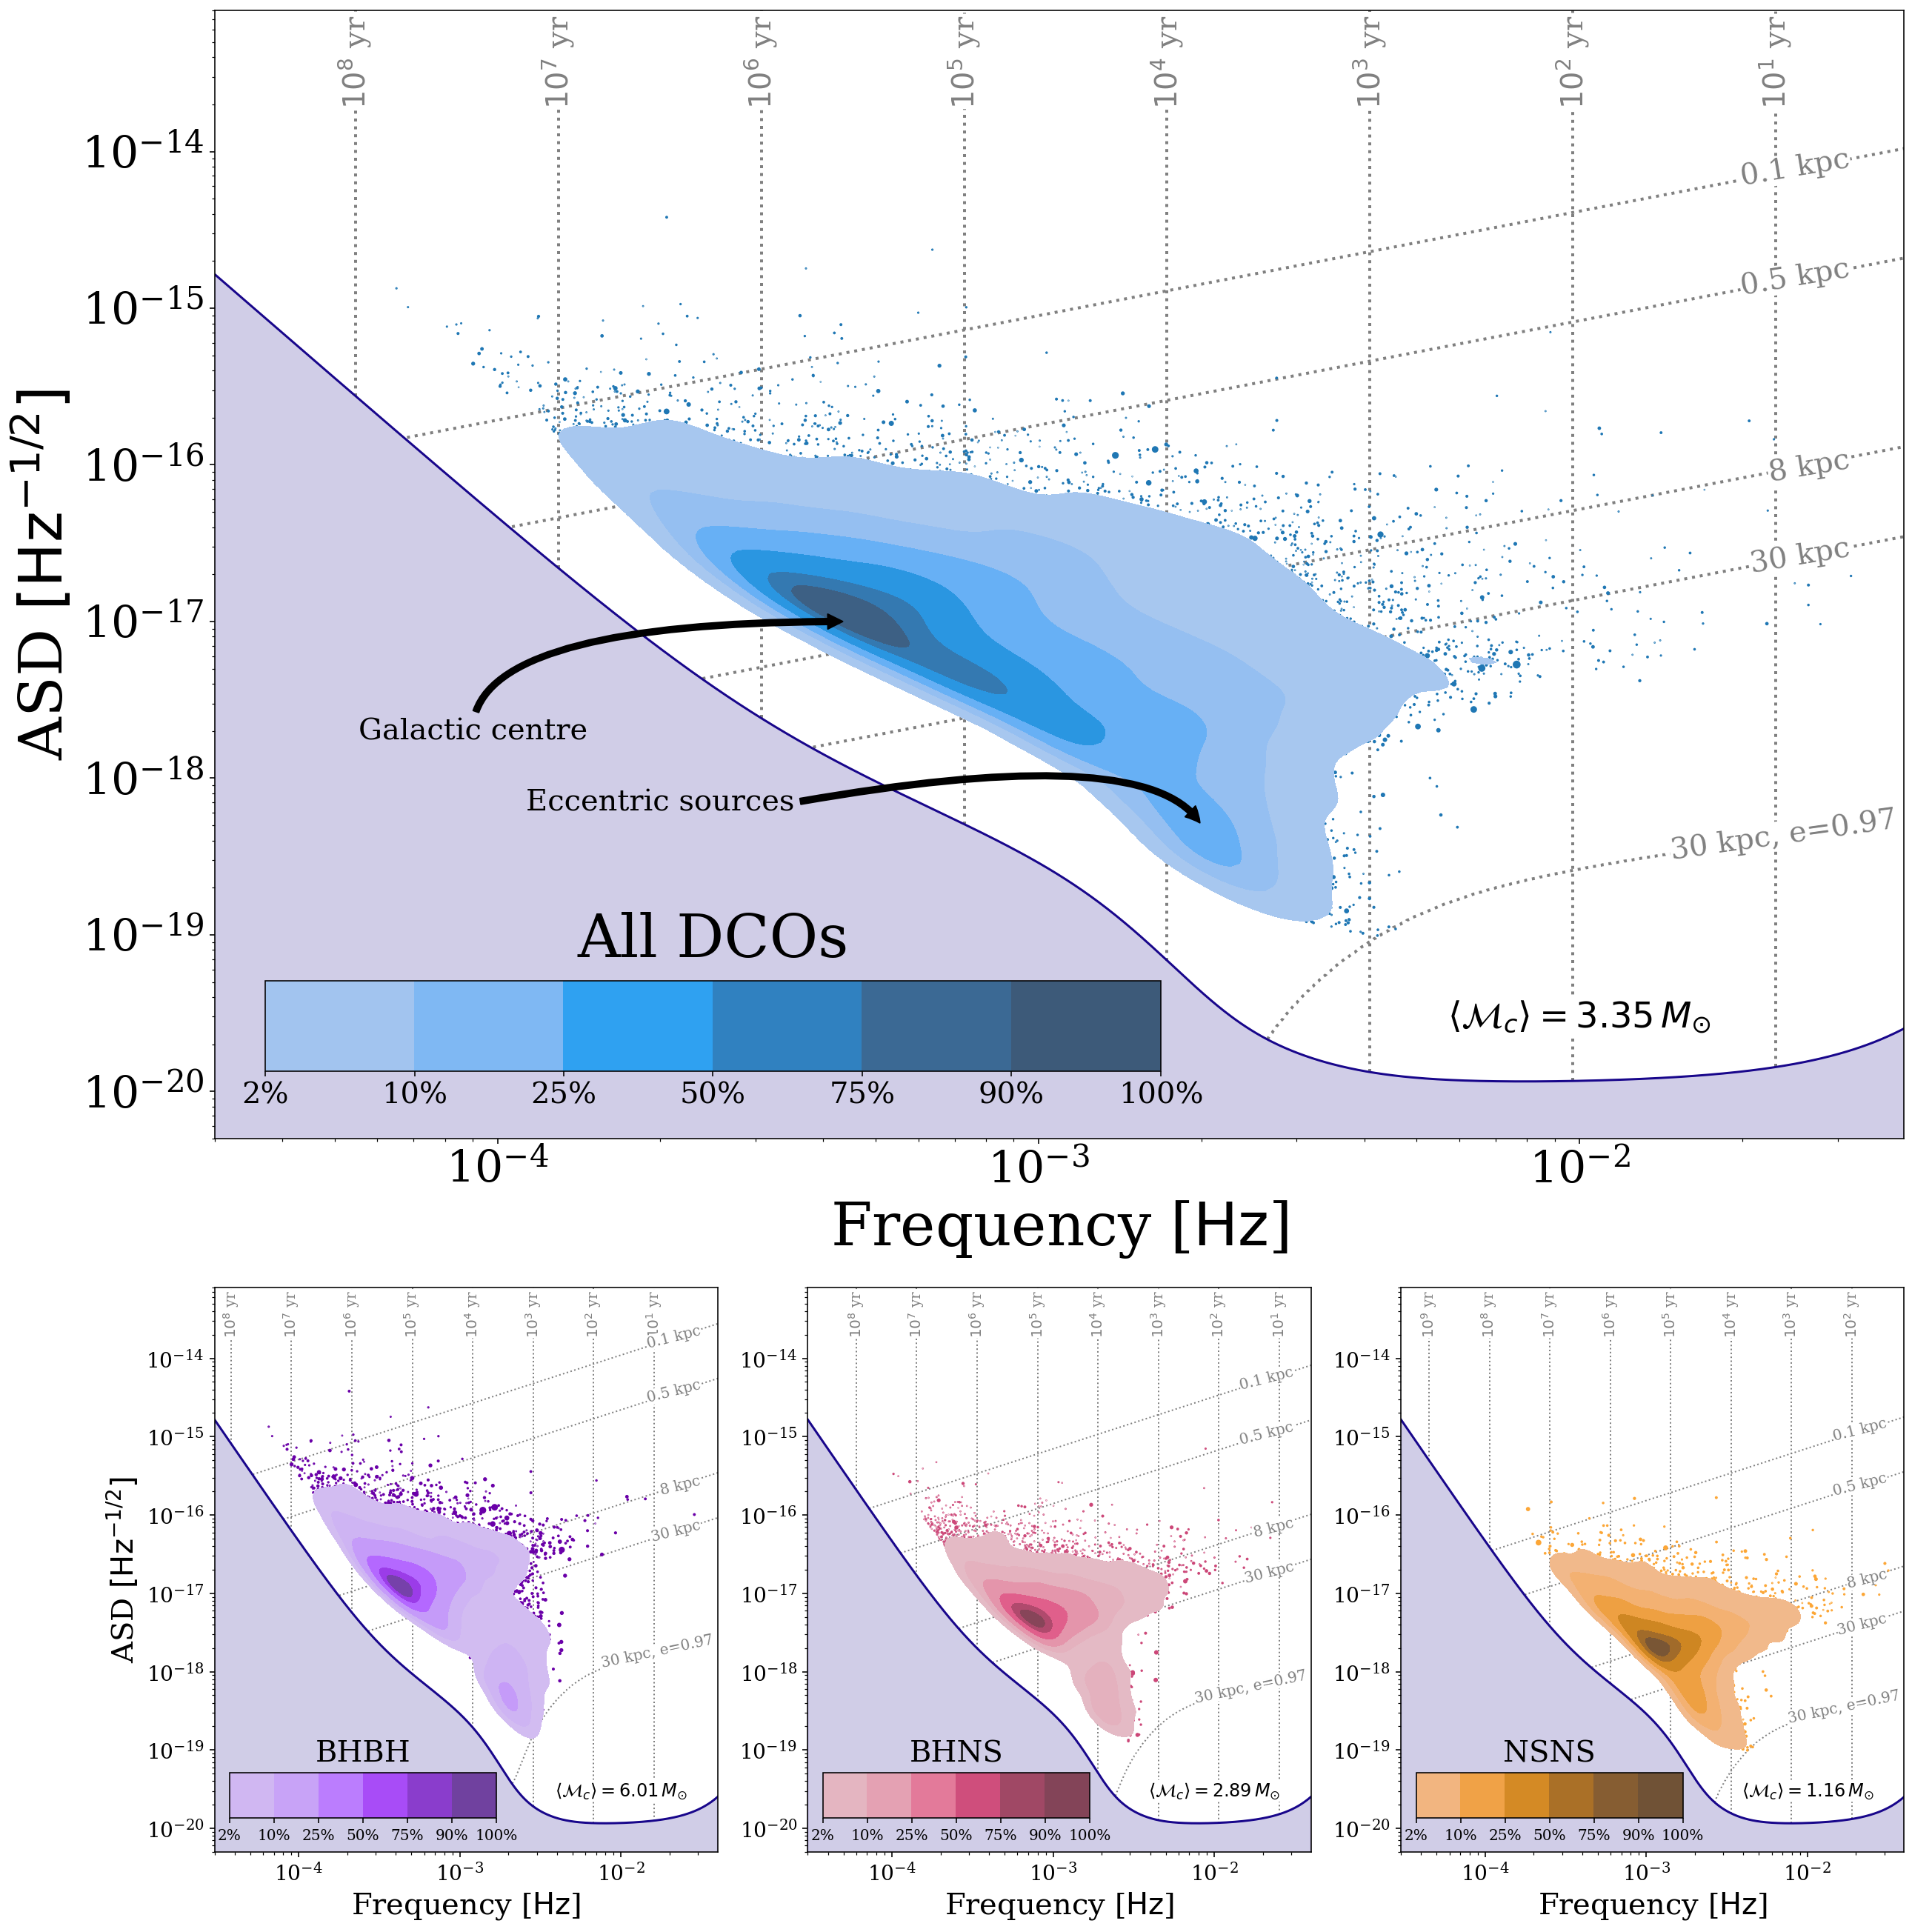

In [51]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig = plt.figure(figsize=(18, 18), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=(2, 1))
all_ax = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

all_mc_mean = np.mean([fid_sources[i].m_c.mean().value for i in range(len(fid_sources))]) * u.Msun
all_mc_min = np.min([fid_sources[i].m_c.min().value for i in range(len(fid_sources))]) * u.Msun
fig, all_ax = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=all_ax,
                                      mc_mean=all_mc_mean,
                                      mc_min=all_mc_min,
                                      line_scale=2, line_rot=8, loc=-10)

all_f_dom = np.concatenate([fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic for i in range(len(fid_sources))])
all_snr = np.concatenate([fid_sources[i].snr for i in range(len(fid_sources))])
all_weight = np.concatenate([fid_sources[i].weight for i in range(len(fid_sources))])

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", s=all_weight * 25) #fid_sources[i].ecc

all_ax.annotate("Galactic centre",
                xy=(4.4e-4, 1e-17), xycoords='data',
                xytext=(9e-5, 2e-18), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=90,angleB=0"),
                fontsize=fs, ha="center", va="center")

all_ax.annotate("Eccentric sources",
                xy=(2e-3, 5e-19), xycoords='data',
                xytext=(2e-4, 7e-19), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=10,angleB=120", relpos=(1.0, 0.5)),
                fontsize=fs, ha="center", va="center")


# the lazy man's guide to colorbars: just plot hidden points
cmap = cmap_from_colour("tab:blue")
scatter = all_ax.scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
inset_all_ax = all_ax.inset_axes([0.03, 0.06, 0.53, 0.08])
cbar = fig.colorbar(scatter, ax=all_ax, cax=inset_all_ax, boundaries=levels, orientation="horizontal")
cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
cbar.ax.tick_params(labelsize=fs)

all_ax.annotate("All DCOs", xy=(0.295, 0.15), xycoords="axes fraction", fontsize=2 * fs, color="black", ha="center", va="bottom")

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", weights=all_weight,
                                                  disttype="kde", fill=True, levels=levels)
print("full done")

for i in range(len(dco_types)):
    fig, axes[i] = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=axes[i],
                                           mc_mean=fid_sources[i].m_c.mean(),
                                           mc_min=fid_sources[i].m_c.min(), line_rot=12, loc=-75)
    
    # the lazy man's guide to colorbars: just plot hidden points
    cmap = cmap_from_colour(dco_colours[dco_types[i]])
    scatter = axes[i].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = axes[i].inset_axes([0.03, 0.06, 0.53, 0.08])
    cbar = fig.colorbar(scatter, ax=axes[i], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
    cbar.ax.tick_params(labelsize=10)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight * 25)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
                                                      disttype="kde", fill=True, levels=levels)

    axes[i].annotate(dco_types[i], xy=(0.295, 0.15), xycoords="axes fraction", fontsize=fs, color="black", ha="center", va="bottom")
    
    print(dco_types[i], "done")

ylims = (5e-21, 8e-14)
    
for ax in [all_ax] + axes:
    if ax in axes[1:]:
        ax.set_ylabel("")
    ax.set_ylim(ylims)
    
all_ax.tick_params(labelsize=1.5 * fs)
all_ax.xaxis.label.set_fontsize(2 * fs)
all_ax.yaxis.label.set_fontsize(2 * fs)

plt.savefig("../../paper/figures/dcos_on_sc.png", dpi=300, bbox_inches="tight")
plt.savefig("../../paper/figures/dcos_on_sc_high_res.png", dpi=600, bbox_inches="tight")

plt.show()

KeyboardInterrupt: 

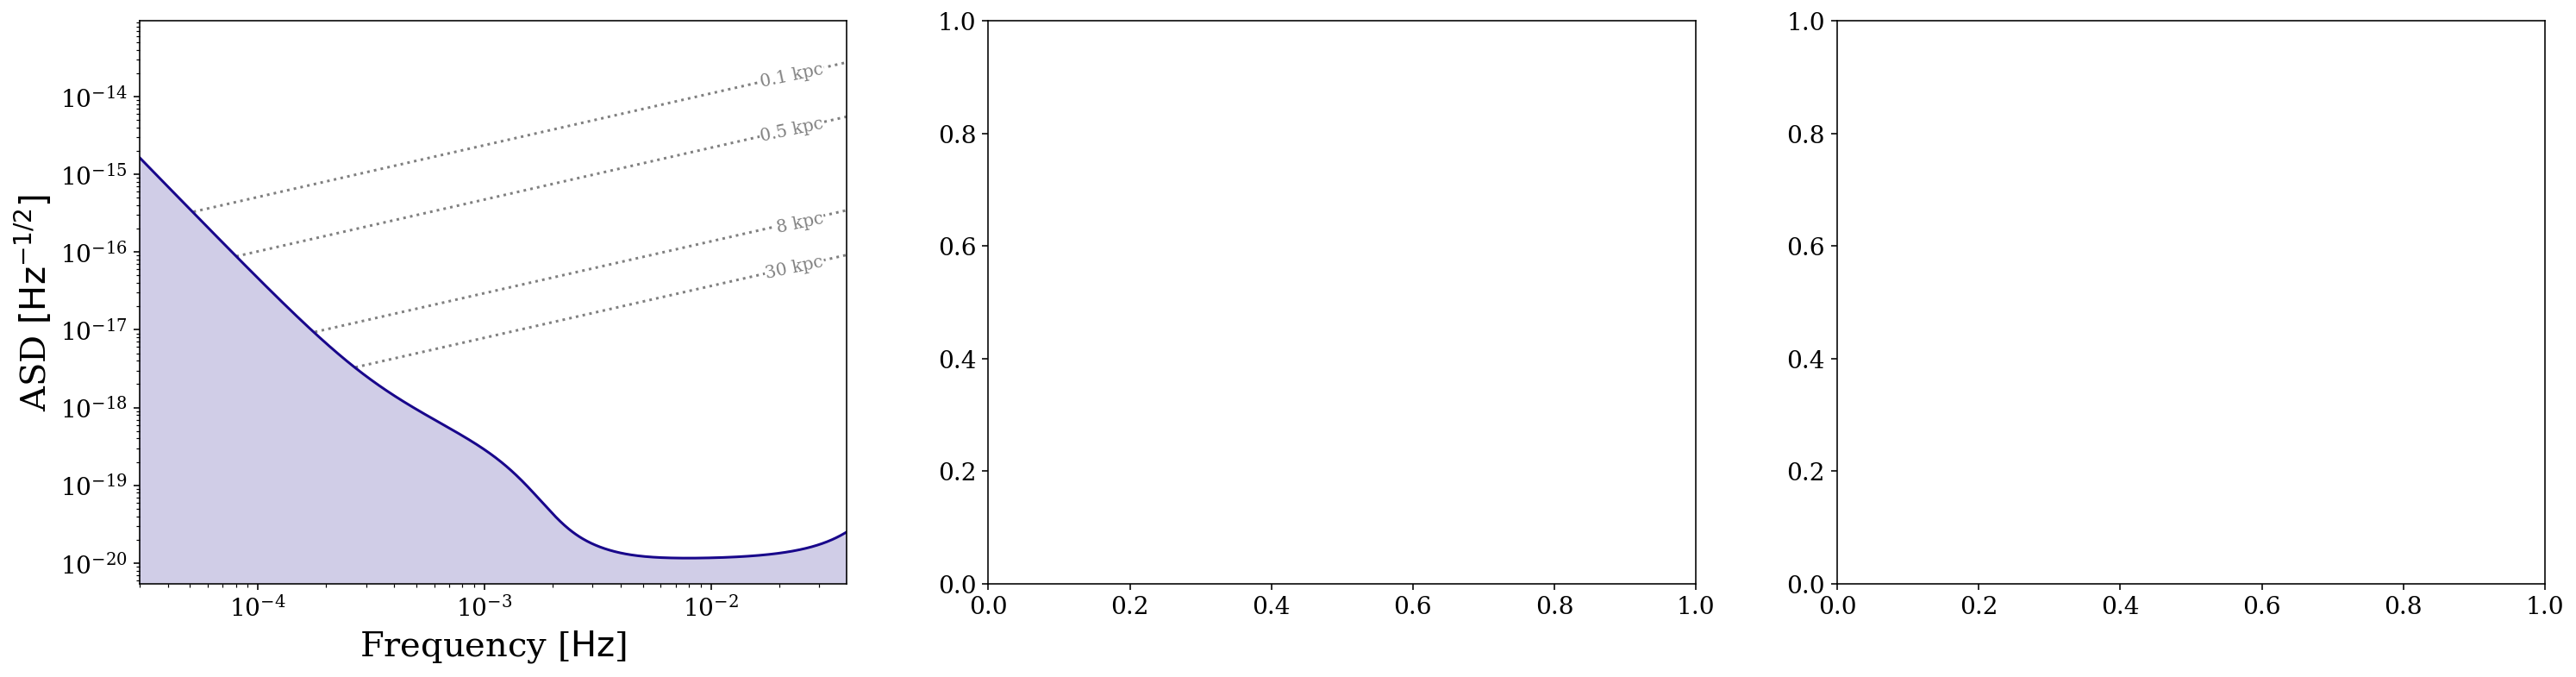

In [73]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig, axes = plt.subplots(1, 3, figsize=(25, 6))

for i in range(len(dco_types)):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=axes[i])
    
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(fid_sources[i].m_c.mean(), line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        axes[i].plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0)
        axes[i].annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * 0.5), xycoords="data", color="grey", rotation=12, 
                         ha="right", va="center", fontsize=10, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.97]:
        nmax = 220 if e_dist_line == 0.9 else 1000
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length),
                                          m_2=np.repeat(fid_sources[i].m_c.min() * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        axes[i].plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=0.7, zorder=0, color="grey", linestyle="--")
    
    ind = -50
    axes[i].annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][ind].value, e_dist_line_signal[:check][mask][ind].value), xycoords="data", color="grey",
                     rotation=10, ha="center", va="center", fontsize=10, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight * 25)
    
#     legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic,
#                                                       snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
#                                                       color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
#                                                       disttype="kde", fill=True, levels=[0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

    axes[i].annotate(dco_types[i], xy=(1e-2, 2e-20), xycoords="data", fontsize=fs, color=dco_colours[dco_types[i]], ha="center", va="bottom")
    
    print(dco_types[i], "done")
    
# fig.colorbar(scatter)    

ylims = (5e-21, 8e-14)
    
for ax in axes:
    if ax != axes[0]:
        ax.set_ylabel("")
    ax.tick_params(labelsize=fs)
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    ax.set_ylim(ylims)
    
# fig.legend(loc='upper center', fontsize=fs, markerscale=20, ncol=3, handletextpad=0, borderaxespad=0.0)

# plt.savefig("../plots/dcos_on_sc.pdf", format="pdf", bbox_inches="tight")
# plt.savefig("../../paper/figures/dcos_on_sc.png", dpi=500, bbox_inches="tight")

plt.show()